## Heat 1D Equation

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Problem

$$\frac{\partial u}{\partial t} = \alpha\frac{\partial^2 u}{\partial x^2},\quad t\in [0, T],\quad x\in [0, L]$$

- Initial condition:

$$u(0, x) = \sin\left(\frac{n\pi x}{L}\right),\quad x\in [0, L]$$

- Boundary conditions:

$$u(t, 0) = u(t, L) = 0,\quad t\in [0, T]$$

- Exact solution:

$$u(t, x) = \sin\left(\frac{n\pi}{L}x\right)\exp\left(-\alpha\frac{n^2\pi^2}{L^2}t\right)$$

In [8]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

def show_result(t, x, U, title=""):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3))
    for idx in (0, 50, 100, 150, 200, -1):
        ax1.plot(x, U[idx, :], label=f't={t[idx]:.2f}')
    ax1.set(xlabel='x', ylabel='u(t, x)', title=title)
    ax1.legend(loc="lower right", fontsize=8, frameon=False)
    ax1.grid(color='k', ls=':', lw=.5)

    img = ax2.imshow(U, cmap='rainbow', aspect='auto', interpolation='bilinear',
                    vmin=np.round(U.min()), vmax=np.round(U.max()),
                    origin='lower', extent=(x.min(), x.max(), t.min(), t.max()))
    ax2.set(xlabel='x', ylabel='t', title=title)
    fig.colorbar(img, ax=ax2)
    fig.tight_layout()
    plt.show()

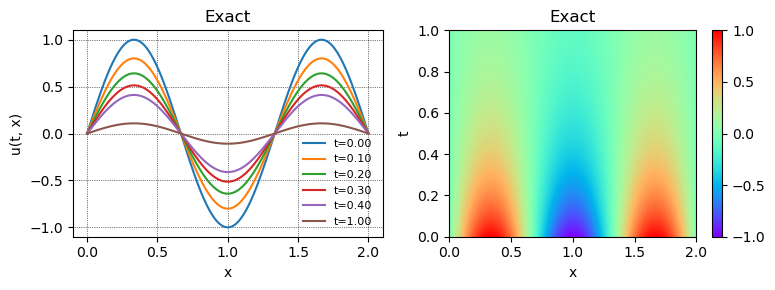

In [9]:
### Problem parameters
def u_exact(t, x, alpha, beta):
    return np.sin(beta * x) * np.exp(-alpha * beta**2 * t)

n = 3
t_min, t_max, t_size = 0, 1, 501
x_min, x_max, x_size = 0, 2, 201
alpha, beta = 0.1, n*np.pi/x_max

t = np.linspace(t_min, t_max, t_size)       # (t_size,)
x = np.linspace(x_min, x_max, x_size)       # (x_size,)
T, X = np.meshgrid(t, x, indexing="ij")     # (t_size, x_size)
U_exact = u_exact(T, X, alpha, beta)        # (t_size, x_size)

show_result(t, x, U_exact, title="Exact")

In [10]:
def to_tensor(x):
    return torch.tensor(x).float().view(-1, 1).to(device)

def to_array(x):
    return x.view(-1).cpu().detach().numpy()

n_pde, n_ic, n_bc = 1000, 100, 100

set_seed(42)
## Domain: u_t - alpha * u_xx = 0
t_pde = np.random.rand(n_pde) * (t_max - t_min) + t_min
x_pde = np.random.rand(n_pde) * (x_max - x_min) + x_min

## Initial condition: u(0, x) = sin(beta * x)
x_ic = np.random.rand(n_ic) * (x_max - x_min) + x_min
t_ic = np.full_like(x_ic, 0)
u_ic = np.sin(beta * x_ic)

## Boundary condition: u(t, 0) = 0
t_bc1 = np.random.rand(n_bc) * (x_max - x_min) + x_min
x_bc1 = np.full_like(t_bc1, x_min)
u_bc1 = np.full_like(t_bc1, 0)

## Boundary condition: u(t, x_max) = 0
t_bc2 = np.random.rand(n_bc) * (t_max - t_min) + t_min
x_bc2 = np.full_like(t_bc2, x_max)
u_bc2 = np.full_like(t_bc2, 0)

## Convert numpy arrays to torch tensors
t_pde, x_pde = to_tensor(t_pde), to_tensor(x_pde)
t_ic, x_ic, u_ic = to_tensor(t_ic), to_tensor(x_ic), to_tensor(u_ic)
t_bc1, x_bc1, u_bc1 = to_tensor(t_bc1), to_tensor(x_bc1), to_tensor(u_bc1)
t_bc2, x_bc2, u_bc2 = to_tensor(t_bc2), to_tensor(x_bc2), to_tensor(u_bc2)

In [11]:
def gradient(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
                               create_graph=True, retain_graph=True)[0]

def residual_loss(model, t, x):
    t.requires_grad = True
    x.requires_grad = True

    u = model(t, x)
    u_t = gradient(u, t)
    u_xx = gradient(gradient(u, x), x)

    residual = u_t - alpha * u_xx
    return torch.mean(residual**2)

def mse_loss(model, t, x, u):
    u_pred = model(t, x)
    return torch.mean((u_pred - u)**2)

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),  nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1),
        )

    def forward(self, t, x):
        tx = torch.hstack([t, x])
        return self.net(tx)

### Training

In [12]:
## Training
n_epochs = 10000
learning_rate = 1e-3

model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

for epoch in range(1, n_epochs + 1):
    model.train()
    loss_pde = residual_loss(model, t_pde, x_pde)
    loss_ic = mse_loss(model, t_ic, x_ic, u_ic)
    loss_bc1 = mse_loss(model, t_bc1, x_bc1, u_bc1)
    loss_bc2 = mse_loss(model, t_bc2, x_bc2, u_bc2)

    loss = loss_pde + loss_ic + loss_bc1 + loss_bc2
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % (n_epochs // 10) == 0:
        print(f"[{epoch:5d}/{n_epochs}] (lr: {scheduler.get_last_lr()[0]:.2e}) "
              f"loss: {loss.item():.2e} "
              f"(pde: {loss_pde.item():.2e} ic: {loss_ic.item():.2e} "
              f"bc1: {loss_bc1.item():.2e} bc2: {loss_bc2.item():.2e})")

[ 1000/10000] (lr: 5.99e-04) loss: 4.96e-03 (pde: 3.00e-03 ic: 8.36e-04 bc1: 1.61e-04 bc2: 9.63e-04)
[ 2000/10000] (lr: 3.58e-04) loss: 1.73e-03 (pde: 9.57e-04 ic: 2.83e-04 bc1: 5.21e-05 bc2: 4.42e-04)
[ 3000/10000] (lr: 2.15e-04) loss: 5.09e-04 (pde: 3.31e-04 ic: 5.56e-05 bc1: 2.07e-05 bc2: 1.01e-04)
[ 4000/10000] (lr: 1.29e-04) loss: 2.41e-04 (pde: 2.02e-04 ic: 1.12e-05 bc1: 9.89e-06 bc2: 1.80e-05)
[ 5000/10000] (lr: 7.69e-05) loss: 1.82e-04 (pde: 1.61e-04 ic: 7.46e-06 bc1: 5.85e-06 bc2: 8.38e-06)
[ 6000/10000] (lr: 4.61e-05) loss: 1.54e-04 (pde: 1.38e-04 ic: 6.30e-06 bc1: 3.73e-06 bc2: 6.47e-06)
[ 7000/10000] (lr: 2.76e-05) loss: 1.36e-04 (pde: 1.22e-04 ic: 5.60e-06 bc1: 2.49e-06 bc2: 5.70e-06)
[ 8000/10000] (lr: 1.65e-05) loss: 1.22e-04 (pde: 1.10e-04 ic: 5.10e-06 bc1: 1.72e-06 bc2: 5.26e-06)
[ 9000/10000] (lr: 9.89e-06) loss: 1.11e-04 (pde: 1.00e-04 ic: 4.73e-06 bc1: 1.23e-06 bc2: 4.97e-06)
[10000/10000] (lr: 5.92e-06) loss: 1.03e-04 (pde: 9.30e-05 ic: 4.45e-06 bc1: 9.16e-07 bc2: 

### Evaluation

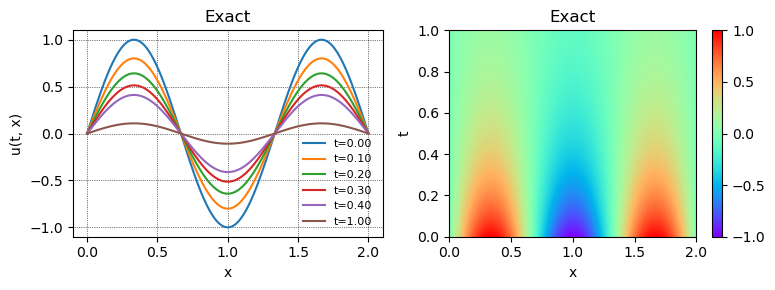

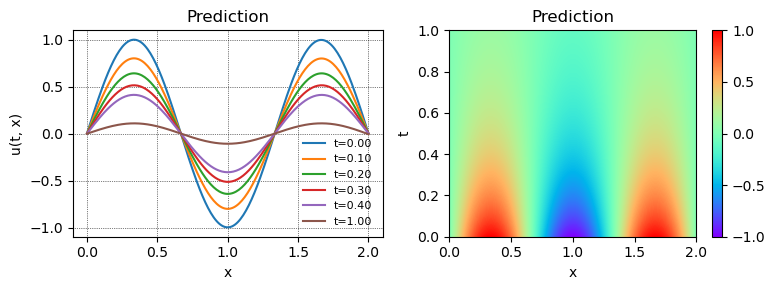

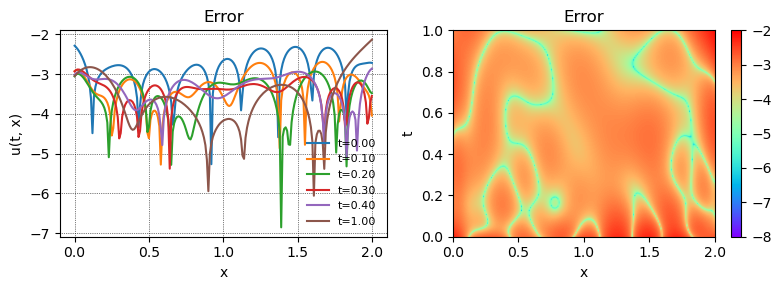

In [13]:
## Evaluation
with torch.no_grad():
    t_test, x_test = to_tensor(T.flatten()), to_tensor(X.flatten())
    U_pred = model(t_test, x_test)

U_pred = to_array(U_pred).reshape(t_size, x_size)

show_result(t, x, U_exact, title="Exact")
show_result(t, x, U_pred, title="Prediction")
show_result(t, x, np.log10(abs(U_exact - U_pred)), title="Error")